Task_1_classic_model_ML
===

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import tsfresh as tsf
from tsfresh import extract_features
import warnings

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [4]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [6]:
import custom_ecg_delineate as custom
reload(custom)
import custom_ecg_delineate as custom

In [7]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 '0': '{:.0%}',
 '1': '{:.0%}',
 '1.0': '{:.0%}',
 '0.0': '{:.0%}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [8]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(1,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    use_lasso                = param.Boolean(True)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [9]:
# df_heart = pd.read_csv('../data_proj2/ptbdb_train.csv')
df_heart_test = pd.read_csv('../data_proj2/ptbdb_test.csv', header=None)
df_heart_train = pd.read_csv('../data_proj2/ptbdb_train.csv', header=None)

In [10]:
df_heart_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.952505,0.587508,0.115810,0.072869,0.003904,0.025374,0.020169,0.020169,0.021470,0.014314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.994152,0.525666,0.248213,0.070825,0.152047,0.258609,0.315789,0.346979,0.352827,0.348928,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
df_heart_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
      dtype='int64', length=188)

In [12]:
df_heart_train.describe().style.format(format_dict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000,11641.000000
mean,0.976530,0.721439,0.402820,0.242706,0.206556,0.215723,0.221038,0.223554,0.226485,0.228690,0.231415,0.233240,0.235998,0.239128,0.241565,0.245459,0.248385,0.251952,0.256260,0.259369,0.263286,0.268197,0.275596,0.285904,0.296167,0.307767,0.317917,0.327244,0.337096,0.344853,0.351245,0.354447,0.355006,0.352592,0.345687,0.337693,0.326263,0.314676,0.302928,0.291419,0.283096,0.275565,0.269475,0.264432,0.261152,0.260856,0.261026,0.261672,0.262772,0.262046,0.262260,0.261307,0.259682,0.258642,0.256207,0.255477,0.252548,0.251015,0.250932,0.251319,0.252904,0.251834,0.251114,0.251032,0.249634,0.250351,0.251658,0.256658,0.257361,0.253206,0.253137,0.254715,0.250684,0.242211,0.235837,0.234976,0.234018,0.236019,0.240379,0.246266,0.250929,0.247341,0.245978,0.247048,0.246609,0.246487,0.238971,0.231700,0.229485,0.227450,0.221959,0.216337,0.214844,0.212890,0.211238,0.213290,0.209309,0.207602,0.206971,0.204077,0.

In [13]:
df_heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11641 entries, 0 to 11640
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 16.7 MB


In [14]:
n_train_examples = df_heart_train.shape[0]
n_test_examples = df_heart_test.shape[0]
n_total_examples = n_train_examples + n_test_examples
print(f'The test split has {n_test_examples} rows, or {n_test_examples/n_total_examples:.2%} of all examples (which represent {n_total_examples} rows).')

The test split has 2911 rows, or 20.00% of all examples (which represent 14552 rows).


## Labels

In [15]:
label_col = list(df_heart_train.columns)[-1]
labels_count = df_heart_train[label_col].value_counts(normalize=True).to_frame().T
labels_count.columns = [str(x) for x in labels_count.columns]
labels_count.style.format(format_dict)

,1.0,0.0
proportion,72%,28%


In [17]:
# Create a list of indexes in each class
idx_by_class = {
		'0.0': [],
		'1.0': [],
}
for idx, row in df_heart_train.iterrows():
		if row[label_col] == 0.0:
			idx_by_class['0.0'].append(idx)
		elif row[label_col] == 1.0:
			idx_by_class['1.0'].append(idx)
		else:
			raise ValueError(f'Unexpected value {row[label_col]} in row {idx}.')

In [18]:
pn.Column(pn.Row(base.param.add_one_hot_encoded, base.param.stand_features, base.param.test_size))

BokehModel(combine_events=True, render_bundle={'docs_json': {'54d3932c-094f-4034-b18f-66649bb5a05f': {'version…

In [19]:
x_train_0, x_test_0, y_train_0, y_test_0 = lib.pre_process_ecg(
        df_heart_train,
        label_col_pos=-1,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        split_data=False,
)

In [20]:
x_train_0.head(3)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Processing

In [26]:
sampling_rate = 125
n_rows = len(x_train_0)
n_rows

11641

In [ ]:
# with warnings.catch_warnings():
# 	warnings.filterwarnings(
#     action='ignore',
#     category=RuntimeWarning,
# 	)
# 	epochs_dict, total_infos_dict, r_peaks_df, ecg_cleaned_df = lib.create_heartbeats_dictionary(
# 			x_train_0.head(n_rows),
# 			sampling_rate = sampling_rate,
# 			method='Neurokit',
# 	)

In [32]:
r_peaks_df = pd.read_csv('../output/r_peaks_df.csv', index_col='heartbeat_idx') 
ecg_cleaned_df = pd.read_csv('../output/ecg_cleaned_df.csv', index_col='heartbeat_idx')

In [33]:
ecg_cleaned_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
0,-0.019281,-0.272707,-0.539191,-0.792092,-0.926972,-0.915586,-0.838858,-0.772988,-0.735368,-0.710220,...,-0.051020,-0.050827,-0.050537,-0.050147,-0.049653,-0.049050,-0.048334,-0.047502,-0.046548,-0.045502
1,-0.059411,-0.715978,-0.909781,-0.820848,-0.823756,-0.879828,-0.885541,-0.867916,-0.851418,-0.846003,...,-0.031817,-0.033256,-0.034559,-0.035721,-0.036732,-0.037587,-0.038276,-0.038792,-0.039127,-0.039323
2,-0.032378,-0.342638,-0.658051,-0.825662,-0.855511,-0.858410,-0.857010,-0.848735,-0.838177,-0.826485,...,-0.044694,-0.045428,-0.046028,-0.046487,-0.046801,-0.046963,-0.046968,-0.046809,-0.046481,-0.046022


In [35]:
r_peaks_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## tsfresh features

In [36]:
df_heart_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.730599,0.472859,0.139526,0.000000,0.020507,0.112183,0.162847,0.180941,0.192199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.152446,0.011377,0.308305,0.153584,0.096701,0.083049,0.086462,0.105802,0.071672,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.975917,0.693234,0.241399,0.107225,0.098050,0.072248,0.062500,0.054472,0.054472,0.045872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
x_train_0_transfo.T.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
heartbeat_idx,,,,,,,,,,,,,,,,,,,,,
11637,1.000000,0.685957,0.263456,0.215702,0.276406,0.259814,0.260219,0.209632,0.231081,0.196681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11638,0.989283,0.793899,0.265458,0.015664,0.000000,0.116241,0.223413,0.291014,0.251443,0.281121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11639,1.000000,0.487234,0.280142,0.127660,0.092908,0.159574,0.142553,0.146809,0.147518,0.131206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11640,1.000000,0.668430,0.507473,0.273396,0.204875,0.122327,0.064842,0.059094,0.055415,0.057484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
id,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [47]:
x_train_0_transfo = x_train_0.T.copy()
x_train_0_transfo['id'] = 1
extracted_features = tsf.extract_features(x_train_0_transfo.iloc[:,-50:], column_id='id')

Feature Extraction: 100%|██████████| 25/25 [00:05<00:00,  4.48it/s]


In [48]:
extracted_features

,11596__variance_larger_than_standard_deviation,11596__has_duplicate_max,11596__has_duplicate_min,11596__has_duplicate,11596__sum_values,11596__abs_energy,11596__mean_abs_change,11596__mean_change,11596__mean_second_derivative_central,11596__median,...,11639__fourier_entropy__bins_5,11639__fourier_entropy__bins_10,11639__fourier_entropy__bins_100,11639__permutation_entropy__dimension_3__tau_1,11639__permutation_entropy__dimension_4__tau_1,11639__permutation_entropy__dimension_5__tau_1,11639__permutation_entropy__dimension_6__tau_1,11639__permutation_entropy__dimension_7__tau_1,11639__query_similarity_count__query_None__threshold_0.0,11639__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,14.890126,4.72843,0.019856,-0.005077,0.00068,0.057427,...,0.552689,0.92176,2.539877,1.493592,2.420178,3.127652,3.540862,3.67643,NaN,0.597974


In [90]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [91]:
lib.tsfresh_features_extraction_loop(
        x_train_0_transfo,
        starting_point=0,
        window_size=50,
				n_loops=20,
)

Feature Extraction:   0%|          | 0/25 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s]


In [77]:
x_train_0_transfo = x_train_0.T.copy()
extracted_features_final = lib.tsfresh_features_extraction(
        x_train_0_transfo,
        starting_point=0,
        window_size=3,
)

Feature Extraction:   0%|          | 0/3 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


In [78]:
extracted_features_final

,variance_larger_than_standard_deviation,has_duplicate_max,has_duplicate_min,has_duplicate,sum_values,abs_energy,mean_abs_change,mean_change,mean_second_derivative_central,median,...,fourier_entropy__bins_5,fourier_entropy__bins_10,fourier_entropy__bins_100,permutation_entropy__dimension_3__tau_1,permutation_entropy__dimension_4__tau_1,permutation_entropy__dimension_5__tau_1,permutation_entropy__dimension_6__tau_1,permutation_entropy__dimension_7__tau_1,query_similarity_count__query_None__threshold_0.0,mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,21.162685,7.935466,0.032056,-0.005376,0.002291,0.000000,...,0.117714,0.176399,1.274168,1.105742,1.719584,2.258974,2.581583,2.731673,NaN,0.669755
2,0.0,0.0,1.0,1.0,18.361812,5.907348,0.022110,-0.005247,0.000764,0.071674,...,0.853715,1.276388,2.616993,1.230186,1.766055,2.281631,2.684533,2.957541,NaN,0.692661
0,0.0,0.0,1.0,1.0,31.761560,8.927965,0.014062,-0.005376,0.000728,0.178528,...,0.161651,0.316683,0.974941,1.566183,2.558113,3.418415,3.910249,4.101044,NaN,0.602734


In [ ]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [ ]:
tsf_fresh_features = lib.join_all_features_csv_batches(
    dir_path='../output/cs_files_tsfresh/extracted_features_',
    pull_all=False,
    starting_point=0,
    window_size= 50,
    n_loops=2,
)

## Other Peaks

In [217]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [221]:
waves_sum_df, peak_index_df, idx_multiple_peaks_waves = lib.heartbeats_other_peaks(
        ecg_cleaned_df,
        r_peaks_df,
        sampling_rate=sampling_rate,
    )

In [220]:
peak_index_df

,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets
heartbeat_idx,,,,,,
0,NaN,NaN,4,139,NaN,143
1,NaN,NaN,2,73,NaN,75
2,NaN,NaN,5,106,NaN,109
3,NaN,NaN,4,120,NaN,123
4,NaN,NaN,3,119,NaN,122
5,NaN,NaN,6,75,NaN,77


In [219]:
waves_sum_df

,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets
heartbeat_idx,,,,,,
0,0,0,1,1,0,1
1,0,0,1,1,0,1
2,0,0,1,1,0,1
3,0,0,1,1,0,1
4,0,0,1,1,0,1
5,0,0,1,1,0,1


In [ ]:
r_peaks_df.to_csv('../output/peak_index_df.csv', index=True) 
ecg_cleaned_df.to_csv('../output/waves_sum_df.csv', index=True) 

In [98]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([110]),
 'ECG_R_Peaks_Uncorrected': array([110]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([nan]),
 'ECG_fixpeaks_drrs': array([nan]),
 'ECG_fixpeaks_mrrs': array([nan]),
 'ECG_fixpeaks_s12': array([0.]),
 'ECG_fixpeaks_s22': array([0.]),
 'ECG_fixpeaks_c1': 0.13,
 'ECG_fixpeaks_c2': 0.17,
 'sampling_rate': 125}

In [101]:
import custom_ecg_delineate as custom
reload(custom)
import custom_ecg_delineate as custom

In [139]:
waves , signals = custom.ecg_delineate_custom(
		ecg_cleaned_df.iloc[0,:],
		r_peaks_df.loc[lala.name,:],
		sampling_rate=sampling_rate,
		method='peak',
		)

In [ ]:
# with warnings.catch_warnings():
# 	warnings.filterwarnings(
#     action='ignore',
#     category=RuntimeWarning,
# 	)
# 	epochs_dict, total_infos_dict, r_peaks_df, ecg_cleaned_df = lib.create_heartbeats_dictionary(
# 			x_train_0.head(n_rows),
# 			sampling_rate = sampling_rate,
# 			method='Neurokit',
# 	)

In [ ]:
import pickle
with open('../output/total_infos_dict.pkl', 'wb') as f:
    pickle.dump(total_infos_dict, f)
# with open('total_infos_dict.pkl', 'rb') as f:
#     total_infos_dict = pickle.load(f)

In [84]:
waves.sum()

ECG_P_Peaks      0
ECG_Q_Peaks      0
ECG_S_Peaks      1
ECG_T_Peaks      1
ECG_P_Onsets     0
ECG_T_Offsets    1
dtype: int64

In [83]:
signals

{'ECG_P_Peaks': [nan],
 'ECG_Q_Peaks': [nan],
 'ECG_S_Peaks': [96],
 'ECG_T_Peaks': [100],
 'ECG_P_Onsets': [nan],
 'ECG_T_Offsets': [104]}

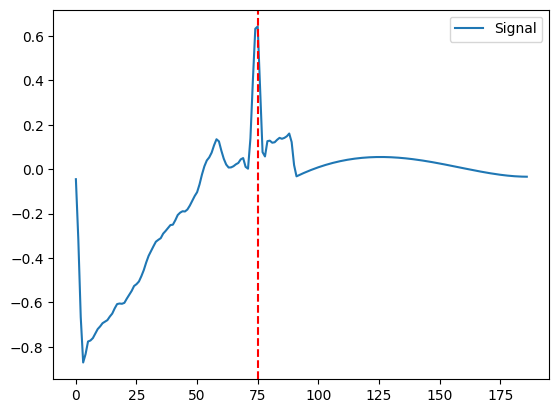

In [48]:
# Extract clean ECG and R-peaks location
rpeaks = info["ECG_R_Peaks"]
# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks, ecg_cleaned)

In [49]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([75]),
 'ECG_R_Peaks_Uncorrected': array([75]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([nan]),
 'ECG_fixpeaks_drrs': array([nan]),
 'ECG_fixpeaks_mrrs': array([nan]),
 'ECG_fixpeaks_s12': array([0.]),
 'ECG_fixpeaks_s22': array([0.]),
 'ECG_fixpeaks_c1': 0.13,
 'ECG_fixpeaks_c2': 0.17,
 'sampling_rate': 125}

In [100]:
import py_lib as lib
reload(lib)
import py_lib as lib

In [52]:
heartbeats = nk.epochs_create(
		ecg_cleaned,
		rpeaks,
		sampling_rate=sampling_rate,
		epochs_start=0,
		epochs_end=187,
)

In [55]:
heartbeats['1']

,Signal,Index,Label
0.000000,0.642672,75,1
0.008000,0.356608,76,1
0.016001,0.076567,77,1
0.024001,0.057187,78,1
0.032001,0.126079,79,1
...,...,...,...
186.967999,0.000000,23445,1
186.975999,0.000000,23446,1
186.983999,0.000000,23447,1
186.992000,0.000000,23448,1


In [70]:
period = nk.signal_period(rpeaks, sampling_rate,)
rate = 60 / period
period

array(nan)

In [71]:
rpeaks

array([75])

In [77]:
waves

,ECG_P_Peaks,ECG_Q_Peaks,ECG_S_Peaks,ECG_T_Peaks,ECG_P_Onsets,ECG_T_Offsets
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
182,0,0,0,0,0,0
183,0,0,0,0,0,0
184,0,0,0,0,0,1
185,0,0,0,0,0,0


In [76]:
signals

{'ECG_P_Peaks': [nan],
 'ECG_Q_Peaks': [nan],
 'ECG_S_Peaks': [78],
 'ECG_T_Peaks': [125],
 'ECG_P_Onsets': [nan],
 'ECG_T_Offsets': [184]}

In [38]:
import graph as gr
reload(gr)
import graph as gr

# Old

In [ ]:
# Find events
row_idx = 520
data = x_train_0.iloc[row_idx, :].to_frame()
col_name = 'ECG_patient_' + str(row_idx)
data.columns = [col_name]
events = nk.events_find(data[col_name], threshold_keep='above')
events
# Plot the location of event with the signals
plot = nk.events.events_plot(events, data)

In [55]:
y_train_0.value_counts()

187
1.0    6727
0.0    2585
Name: count, dtype: int64

In [56]:
y_train_0.shape

(9312, 1)

In [58]:
y_train_0

,187
patient_idx,
381,1.0
4453,0.0
1155,1.0
4832,1.0
10485,1.0
...,...
11284,1.0
5191,1.0
5390,1.0


In [84]:
x_train_0.head(3)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
patient_idx,,,,,,,,,,,,,,,,,,,,,
381,0.929947,0.977233,0.947110,0.809457,0.359370,0.103678,0.000000,0.053940,0.186340,0.309282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4453,0.940968,0.612751,0.164109,0.127509,0.069658,0.096812,0.112751,0.100354,0.085596,0.079693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1155,0.963608,0.525844,0.085443,0.000000,0.040084,0.039557,0.027426,0.036392,0.047996,0.068038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
data_example.head(3)

,ECG,EDA,Photosensor,RSP
0,-0.015869,13.196868,5.0,0.778931
1,-0.011703,13.197173,5.0,0.777588
2,-0.009766,13.197020,5.0,0.777435


In [103]:
data[col_name]

0      0.936643
1      1.000000
2      0.736773
3      0.450686
4      0.303070
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: ECG_patient_7, Length: 187, dtype: float64

In [178]:
row_idx = 7
sampling_rate = 125
data = x_train_0.iloc[row_idx, :]
nk.ecg_process(data, sampling_rate=sampling_rate, method='neurokit')
# Assess signal quality
quality = nk.ecg_quality(
		ecg_cleaned, rpeaks=info["ECG_R_Peaks"], sampling_rate=sampling_rate
)


/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ValueError: The data length is too small to be segmented.

In [184]:
sampling_rate * 4

500

In [186]:
len(ecg_cleaned)

187

In [181]:
rate

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [182]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([139]),
 'ECG_R_Peaks_Uncorrected': array([139]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([nan]),
 'ECG_fixpeaks_drrs': array([nan]),
 'ECG_fixpeaks_mrrs': array([nan]),
 'ECG_fixpeaks_s12': array([0.]),
 'ECG_fixpeaks_s22': array([0.]),
 'ECG_fixpeaks_c1': 0.13,
 'ECG_fixpeaks_c2': 0.17,
 'sampling_rate': 125}

In [173]:
instant_peaks.describe()

,ECG_R_Peaks
count,187.000000
mean,0.005348
std,0.073127
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [167]:
bio_placeholder = []
sampling_rate=125
for idx, ecg_raw in x_train_0.head(50).iterrows():
	try:
		# data_clean, info = nk.bio_process(
		# 	ecg=ecg_raw, 
		# 	sampling_rate=sampling_rate,
		# )
		# # bio_placeholder.append({'data_clean': data_clean, 'info': info})
		# bio_placeholder.append(data_clean, info)
		ecg_processed = nk.ecg_process(data, sampling_rate=sampling_rate, method='neurokit')
		bio_placeholder.append(ecg_processed)
	except:
		print("Something else went wrong")


/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detect

Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong


/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detect

Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong
Something else went wrong


/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detect

In [168]:
bio_placeholder

[]

In [101]:
import neurokit2 as nk
reload(nk)
import neurokit2 as nk

In [157]:
row_idx = 20
sampling_rate=125
data = x_train_0.iloc[row_idx, :].to_frame()
col_name = 'ECG_patient_' + str(row_idx)
data.columns = [col_name]
data_clean, info = nk.bio_process(
    		ecg=data[col_name], 
        sampling_rate=sampling_rate,
                )

# Visualize some of the channels
data_clean.plot(subplots=True)

/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pinolej/.venv_2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pinolej/.venv_2/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ValueError: The data length is too small to be segmented.

In [147]:
info = {"method_peaks": method.lower(), "method_fixpeaks": "None"}
nk.ecg_findpeaks(
		ecg_cleaned,
		sampling_rate=sampling_rate,
		method=info["method_peaks"],
		avgwindow=0.3,
		# **kwargs
)

{'ECG_R_Peaks': array([123])}

In [145]:
grad = np.gradient(ecg_cleaned)
absgrad = np.abs(grad)
smoothwindow=0.1
avgwindow=0.1
smooth_kernel = int(np.rint(smoothwindow * sampling_rate))
avg_kernel = int(np.rint(avgwindow * sampling_rate))

smoothgrad = nk.signal_smooth(absgrad, kernel="boxcar", size=smooth_kernel)
if isinstance(smoothgrad, pd.Series):
		smoothgrad = smoothgrad.values

length = len(smoothgrad)
print(f'avgwindow: {avgwindow}, avg_kernel: {avg_kernel}, sampling_rate: {sampling_rate}, length: {length}')
# avggrad = nk.signal_smooth(smoothgrad, kernel="boxcar", size=avg_kernel)

avgwindow: 0.1, avg_kernel: 36, sampling_rate: 360, length: 187


In [137]:
smoothgrad

array([0.12602228, 0.12084133, 0.1157036 , 0.11062842, 0.10563323,
       0.10072464, 0.09590684, 0.09117741, 0.0865224 , 0.08191425,
       0.07731124, 0.07266487, 0.06792295, 0.06303292, 0.05795303,
       0.05265309, 0.04717671, 0.04192413, 0.03686265, 0.03193709,
       0.02722929, 0.02316988, 0.02019321, 0.01839147, 0.01760045,
       0.01748251, 0.01749992, 0.01705407, 0.01645991, 0.01601085,
       0.01573506, 0.01556433, 0.01542217, 0.01527925, 0.01512869,
       0.01496955, 0.01480096, 0.01461559, 0.01440515, 0.0141612 ,
       0.0138687 , 0.01351168, 0.01307507, 0.01255541, 0.01196469,
       0.01132903, 0.01068509, 0.01007291, 0.00954565, 0.0091621 ,
       0.00895943, 0.00895914, 0.00910981, 0.00900721, 0.00868701,
       0.00820356, 0.00762356, 0.00702359, 0.00646785, 0.00600608,
       0.00568108, 0.00551217, 0.00549223, 0.00559706, 0.00574202,
       0.00584507, 0.00591475, 0.00596872, 0.00602479, 0.00608534,
       0.00614546, 0.00619996, 0.00624583, 0.00628102, 0.00629

In [134]:
avgwindow=0.75
smoothwindow=0.1
avg_kernel = int(np.rint(avgwindow * sampling_rate))
avg_kernel

270

In [ ]:
avggrad = signal_smooth(smoothgrad, kernel="boxcar", size=avg_kernel)